In [120]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import newton
import pandas as pd
import os
from termcolor import colored
from typing import Tuple, Dict

<div class="alert alert-info" align="center"><b>PROFIL MODIFIÉ ARIANE IV</b></div>

In [121]:
Mach = 5
gamma = 1.4

In [122]:
# Première section du profil : section coiffe
point_nbr = 1000
radius_cover = 1.5
length_cover = 8 * radius_cover
x_cover = np.linspace(0, length_cover, point_nbr)
y_cover = radius_cover * (1 + np.sqrt(1 - np.square(np.divide(x_cover - length_cover, length_cover)))) - radius_cover

# Seconde section du profil : section droite
x_line_1 = np.linspace(length_cover, length_cover + 2 * radius_cover, point_nbr)
y_line_1 = np.full(point_nbr, radius_cover)

# Troisième section du profil : pente
length_slope_1 = length_cover + 2 * radius_cover
x_slope = np.linspace(length_slope_1, length_slope_1 + 3 * radius_cover, point_nbr)
slope_ang_1 = (0.5 * radius_cover - radius_cover) / (x_slope[-1] - x_slope[0])
y_slope = radius_cover + slope_ang_1 * (x_slope - x_slope[0])

# Quatrième section du profil : dièdre
x_start_diedre = length_slope_1 + 3 * radius_cover
length_diedre = 2 * radius_cover
slope_ang_2 = (1.5 * radius_cover - 0.5 * radius_cover) / length_diedre
x_diedre = np.linspace(x_start_diedre, x_start_diedre + length_diedre, point_nbr)
y_diedre = 0.5 * radius_cover + slope_ang_2 * (x_diedre - x_diedre[0])

# Cinquième section du profil : section droite 2
x_start_line_2 = x_start_diedre + length_diedre
x_line_2 = np.linspace(x_start_line_2, x_start_line_2 + 3 * radius_cover, point_nbr)
y_line_2 = np.full(point_nbr, 1.5 * radius_cover)

# Sixième section du profil : section booster
x_start_booster = x_start_line_2 + 3 * radius_cover
length_booster = 30
radius_booster = 2.5
x_booster = np.linspace(x_start_booster, x_start_booster + length_booster, point_nbr)
y_booster = 1.5 * radius_cover + radius_booster * (1 + np.sqrt(1 - np.square((x_booster - (x_start_booster + length_booster)) / length_booster))) - radius_booster

# Profil complet
x_profil = np.concatenate([x_cover[:point_nbr - 1], x_line_1[:point_nbr - 1], x_slope[:point_nbr - 1], x_diedre[:point_nbr - 1], x_line_2[:point_nbr - 1], x_booster])
y_profil = np.concatenate([y_cover[:point_nbr - 1], y_line_1[:point_nbr - 1], y_slope[:point_nbr - 1], y_diedre[:point_nbr - 1], y_line_2[:point_nbr - 1], y_booster])

In [123]:
profil_equation = {
    # Profil complet
    'x_val': x_profil,
    'y_val': y_profil,

    # caractéristiques
    'radius_cover': radius_cover,
    'length_cover': length_cover,
    'radius_booster': radius_booster,
    'length_booster': length_booster
}

profil = {

    'section_1': {
        'x_section': np.concatenate([x_cover[:point_nbr - 1], x_line_1[:point_nbr - 1]]),
        'y_section': np.concatenate([y_cover[:point_nbr - 1], y_line_1[:point_nbr - 1]])
    },
    
    'section_2': {
        'x_section': x_slope[:point_nbr - 1],
        'y_section': y_slope[:point_nbr - 1]
    },

    'section_3':{
        'x_section': x_diedre[:point_nbr - 1],
        'y_section': y_diedre[:point_nbr - 1]
    },

    'section_4':{
        'x_section': x_line_2[:point_nbr - 1],
        'y_section': y_line_2[:point_nbr - 1]
    },

    'section_5': {
        'x_section': x_booster,
        'y_section': y_booster
    }
    
}

section_shape = np.concatenate(([0], np.cumsum(np.array([len(section['x_section']) for section in profil.values()]))))

for index, section in enumerate(profil.values()):
    section["interval"] = (section_shape[index], section_shape[index + 1])

In [124]:
ATM_SEA_LEVEL = {
    'Pressure': 101325,
    'Temperature': 288.15,
    'Density': 1.225,
    'Viscosity': 1.458 * 1e-6,
    'Tz': -6.5*1e-3,
    'gamma': 1.4,
    'r_air': 8.314 / (28.966*1e-3),
    'Cp': ((8.314 / (28.966*1e-3)) * 1.4) / (1.4 - 1),
    'Cv': (8.314 / (28.966*1e-3)) / (1.4 - 1),
    'gravity': 9.80665
}

def Get_ATM_at_Z(ATM_SEA_LEVEL, z) -> dict:

    Pressure_Z = ATM_SEA_LEVEL["Pressure"] * (1 + (ATM_SEA_LEVEL["Tz"]/ATM_SEA_LEVEL["Temperature"])* z) ** (- ATM_SEA_LEVEL["gravity"] / (ATM_SEA_LEVEL["Tz"] * ATM_SEA_LEVEL["r_air"]))

    Temperature_Z = ATM_SEA_LEVEL["Temperature"] + z * ATM_SEA_LEVEL["Tz"]

    Density_Z = Pressure_Z / (Temperature_Z * ATM_SEA_LEVEL["r_air"])

    Viscosity_Z = ATM_SEA_LEVEL["Viscosity"] * ( Temperature_Z ** (3/2) / (110.4 + Temperature_Z))

    ATM_Z_LEVEL = {
        'Pressure': Pressure_Z,
        'Temperature': Temperature_Z,
        'Density': Density_Z,
        'Viscosity': Viscosity_Z
    }

    return ATM_Z_LEVEL

Docs_path = os.getcwd().replace("src", "Docs")

if not os.path.exists(Docs_path):
    os.makedirs(Docs_path)
    print(f"{colored('Docs', 'green')} a été crée.")

subdirs = ["Abaques", "Output"]
path_stock = {}
for subdir in subdirs:
    subdir_path = os.path.join(Docs_path, subdir)
    if not os.path.exists(subdir_path):
        os.makedirs(subdir_path)
        print(f"Le répertoire '{colored(subdir, 'green')}' a été créé dans '{colored(Docs_path, 'yellow')}'.")
        path_stock[subdir] = subdir_path

Output_path = os.path.join(os.getcwd().replace("src", "Docs"), "Output")
Abaques_path = os.getcwd().replace("src", "Docs\Abaques")

z = 5000
FreeFlowVelocity = 3000 # m/s

ATM_Z_LEVEL = Get_ATM_at_Z(ATM_SEA_LEVEL=ATM_SEA_LEVEL, z=z)
print(ATM_Z_LEVEL)

Atmosphere = {
    'ATM_SEA_LEVEL': ATM_SEA_LEVEL,
    'ATM_Z_LEVEL': ATM_Z_LEVEL
}

directory_path = {
    'Abacus': Abaques_path,
    'Output': Output_path
}

profil_dictionary = {
    'profil_equation': profil_equation,
    'profil': profil,
    'section_shape': section_shape
}

{'Pressure': 54016.72743352968, 'Temperature': 255.64999999999998, 'Density': 0.7361409517244275, 'Viscosity': 1.6281177399287062e-05}


In [125]:
class HypersonicObliqueShock:

    def __init__(self, Atmosphere, directory_path, altitude, profil_dictionary, FreeFlowVelocity) -> None:

        # attribut
        self.Sea_Lvl = Atmosphere['ATM_SEA_LEVEL']
        self.Z_Lvl = Atmosphere["ATM_Z_LEVEL"]
        self.gamma = self.Sea_Lvl['gamma']

        self.path_Abacus = directory_path['Abacus']
        self.path_Output = directory_path['Output']
        
        self.profil_equation = profil_dictionary['profil_equation']
        self.profil = profil_dictionary['profil']
        self.section_shape = profil_dictionary['section_shape']
        self.FreeFlowVelocity = FreeFlowVelocity

        # method
            # Abacus loading and directories creation
        self.NormalShock, self.PrandtMeyer = self.LoadAbacus()
        self.Sim_path, self.ObliqueShock_path = self.simulationDir(altitude=altitude)

            # Infinite Mach Number & flow angles
        self.MachInf = self.Get_MachNumber()
        self.Theta, self.Beta = self.Get_DeviationAndShockAngle()
        self.ProfilGraphics()

            # Update profil dictionary to find the more accurate method
        self.profil = self.Get_Method(tol=0.98)
        self.FlowCharacteristics = self.Get_Variable()
        self.DownstreamVar_Graphics(altitude=altitude)
        
            # Stagnation variable upstream and downstream
        self.UpstreamVarStag, self.DownstreamVarStag = self.Stagnation(altitude=altitude)
        pass

    # Abacus loading and directories creation
    def LoadAbacus(self):

        def CheckDataDType(Abacus):

            for col in Abacus.columns.tolist():
                Abacus[col] = Abacus[col].astype(float)

            return Abacus

        try:
            NormalShock_path = os.path.join(self.path_Abacus, "NormalShockProperties.csv")
            PrandtMeyer_path = os.path.join(self.path_Abacus, "PrandtlMeyerFunctionAndMachAngle.csv")
            try:
                NormalShock = CheckDataDType(Abacus=pd.read_csv(NormalShock_path, sep=';'))
                PrandtMeyer = CheckDataDType(Abacus=pd.read_csv(PrandtMeyer_path, sep=';'))
            except Exception as error1:
                print(f"{colored('ERROR', 'red')} : {error1}")
            print(f"{colored('Abacus loading complete!', 'green')}")
        except Exception as error2:
            print(f"{colored('ERROR', 'red')} : {error2}")

        return NormalShock, PrandtMeyer

    def simulationDir(self, altitude) -> Tuple[str, str]:

        Sim_path = os.path.join(self.path_Output, f"Profil_R={self.profil_equation['radius_cover']}_Length={self.profil_equation['length_cover']}_z={altitude}")
        ObliqueShock = os.path.join(Sim_path, "ObliqueShock")

        for directory in [Sim_path, ObliqueShock]:
            if not os.path.exists(directory):
                os.makedirs(directory)
                print(f"Le répertoire {colored(directory, 'yellow')} a été créé.")
            else:
                print(f"Le répertoire {colored(directory, 'yellow')} existe déjà.")

        return Sim_path, ObliqueShock
    
    # Infinite Mach Number & flow angles
    def Get_MachNumber(self) -> float:
        SoundSpeed = np.sqrt(self.gamma * self.Sea_Lvl['r_air'] * self.Z_Lvl['Temperature'])
        self.Z_Lvl['SoundSpeed'] = SoundSpeed
        return self.FreeFlowVelocity / SoundSpeed
    
    def Get_DeviationAndShockAngle(self):

        dy_dx = np.gradient(self.profil_equation['y_val'], self.profil_equation['x_val'])
        dy_dx[np.abs(dy_dx) < 1e-10] = 0

        Theta = np.arctan(dy_dx)
        Beta = np.zeros_like(Theta)

        def cotangent(angle):
            return np.cos(angle) / np.sin(angle)

        def betaEquation(beta, Mach, theta, gamma):
            left_side = np.tan(theta)
            right_side = 2 * cotangent(beta) * ((Mach**2 * np.sin(beta)**2 - 1) / (Mach**2 * (gamma + np.cos(2 * beta)) + 2))
            return left_side - right_side

        for index, theta_i in enumerate(Theta):
            try:
                beta_init = np.radians(30) 
                beta = newton(betaEquation, beta_init, args=(self.MachInf, theta_i, self.gamma))
                Beta[index] = beta
            except RuntimeError:
                Beta[index] = np.nan 

        return Theta, Beta
    
    def ProfilGraphics(self):

        y_min = -5 * self.profil_equation['radius_cover']
        y_max = 5 * self.profil_equation['radius_cover']
        x_section_1 = self.profil_equation['length_cover'] + 2 * self.profil_equation['radius_cover']
        x_section_2 = x_section_1 + 3 * self.profil_equation['radius_cover']
        x_section_3 = x_section_2 + 2 * self.profil_equation['radius_cover']
        x_section_4 = x_section_3 + 3 * self.profil_equation['radius_cover']
        x_section_5 = x_section_4 + self.profil_equation['length_booster']
        x_value = [0, x_section_1, x_section_2, x_section_3, x_section_4, x_section_5]
        mu = np.arcsin(np.divide(1, self.MachInf))

        fig, axs = plt.subplots(2, 1, figsize=(15, 9), sharex='all')

        axs[0].plot(x_profil, y_profil, color='grey', label='profil')
        axs[0].plot(x_profil, -y_profil, color='grey', linestyle='-.', label='symetry')
        axs[0].fill_between(x_profil, y_profil, - y_profil, color='grey', hatch='//', alpha=0.5)
        for value in x_value:
            axs[0].vlines(value, y_min, y_max, color='#FF6500', linestyle='-.')
        axs[0].grid('on')
        axs[0].set_ylim([-3 * radius_booster, 3 * radius_booster])
        axs[0].set_ylabel(r"$Profil$")
        axs[0].legend(loc='upper right')
        axs[0].set_title('Studying Profil')


        axs[1].plot(x_profil, np.degrees(self.Theta), color='navy', label=r"Angle de déviation $\theta$")
        axs[1].plot(x_profil, np.degrees(self.Beta), color='red', linestyle='--', label=r"Angle de choc $\beta$")
        axs[1].plot(x_profil, np.full(len(x_profil), mu), color='purple', linestyle='-.', label=r"Angle de Mach $\mu$")
        axs[1].legend(loc='upper right')
        axs[1].grid('on')
        axs[1].set_xlabel(r"$Unit\ of\ length$")  
        axs[1].set_ylabel(r"$Angle\ [\degree]$")
        axs[1].set_ylim([np.rad2deg(np.nanmin(self.Beta[np.isfinite(self.Beta)])) - 20, np.rad2deg(np.nanmax(self.Theta[np.isfinite(self.Theta)])) + 20])

        plt.show()

    # Update profil dictionary to find the more accurate method
    def Get_Method(self, tol) -> Dict:
        mask_neg = self.Theta < 0
        neg_arr = np.where(mask_neg == True)[0]

        if np.any(neg_arr):
            
            idx_start = np.searchsorted(self.section_shape, neg_arr[0], side='right')
            idx_end = np.searchsorted(self.section_shape, neg_arr[-1], side='right')

            if idx_start == idx_end:
                interval = (self.section_shape[idx_start - 1], self.section_shape[idx_end])

                for section in self.profil.values():
                    if section["interval"] == interval:
                        section["method"] = "Prandtl-Meyer"

        for section in self.profil.values():
            interval = section["interval"]
            theta_section = self.Theta[interval[0]:interval[1]]
            
            ref_value = np.median(theta_section)
            close_values = np.isclose(theta_section, ref_value, rtol=1e-5)
            ratio_close = np.sum(close_values) / len(theta_section)

            if np.isclose(ref_value, 0):
                section["method"] = "Rankine-Hugoniot"
            elif np.all(theta_section >= 0) and ratio_close >= tol:
                section["method"] = "Diedre"
            elif np.all(theta_section >= 0):
                section["method"] = "Rankine-Hugoniot"

        return self.profil
    
    def Variable_DownstreamOfShock(self, Mach) -> Dict:

        Pressure = ((2 * self.gamma * Mach**2) / (self.gamma + 1) - ((self.gamma - 1) / (self.gamma + 1))) * self.Z_Lvl["Pressure"]

        Temperature = np.divide(np.multiply((1 + 0.5 * (self.gamma - 1) * Mach**2), ((2 * self.gamma) / (self.gamma - 1)) * Mach**2 - 1), Mach**2 * np.divide((self.gamma + 1)**2, 2 * (self.gamma - 1))) * self.Z_Lvl["Temperature"]

        Density = (((self.gamma + 1) * Mach**2) / ((self.gamma - 1) * Mach**2 + 2)) * self.Z_Lvl["Density"]

        Mach_n = np.sqrt(np.divide((self.gamma - 1) * Mach**2 + 2, 2 * self.gamma * Mach**2 - (self.gamma - 1)))

        SoundSpeed_n = np.sqrt(np.divide(Temperature, ATM_Z_LEVEL["Temperature"])) * self.Z_Lvl["SoundSpeed"]

        return {
            'Pressure': Pressure,
            'Temperature': Temperature,
            'Density': Density,
            'Mach_n': Mach_n,
            'SoundSpeed_n': SoundSpeed_n,
            'Velocity_n': Mach_n * SoundSpeed_n,
        } 
    
    def PrandtlMeyerVar(self, Mach, interval, Pressure_Up): # Mach_up --> Nombre de Mach normal avant l'expansion

        def PrandtlMeyer_Fnc(Mach):
            lambda_ = np.sqrt((self.gamma - 1) / (self.gamma + 1))
            return (1/lambda_) * np.arctan(lambda_ * np.sqrt(Mach**2 - 1)) - np.arctan(np.sqrt(Mach**2 - 1))
        
        def invPrandtlMeyer(Mach_i, nu_target):
            nu_current = PrandtlMeyer_Fnc(Mach=Mach_i)
            return nu_current - nu_target
        
        def PressureRatio(Mach_upp, Mach_down):
            return np.divide(1 + 0.5 * (self.gamma - 1)* Mach_upp**2, 1 + 0.5 * (self.gamma - 1)* Mach_down**2)**(-self.gamma/(self.gamma-1))
        
        # expression de Mach au point d'impact
        Mach_n_c = np.sqrt(np.divide((self.gamma - 1) * Mach**2 + 2, 2 * self.gamma * Mach**2 - (self.gamma - 1)))
        Mach_c = Mach_n_c / (self.Beta[interval[0] - 1] - self.Theta[interval[0] - 1])

        nu_c = PrandtlMeyer_Fnc(Mach=Mach_c) # Mach ambiant after shock
        delta_arr = self.Theta[interval[0] - 1] + self.Theta[interval[0]:interval[1]]

        nu_arr = np.zeros(interval[1] - interval[0] - 1)
        Mach_arr = np.zeros(interval[1] - interval[0] - 1)
        Pressure_arr = np.zeros(interval[1] - interval[0] - 1) 
        nu_arr[0] = nu_c
        Mach_arr[0] = Mach_c
        Pressure_arr[0] = PressureRatio(Mach_upp=Mach_c, Mach_down=Mach) * Pressure_Up

        for index in range(interval[1] - interval[0]):
            nu_i = nu_arr[0] + delta_arr[index]
            print(f"{colored(nu_i, 'blue')}")
            Mach_i = newton(invPrandtlMeyer, Mach_arr[index], args=(nu_i, ))

            nu_arr[index + 1] = nu_i
            Mach_arr[index + 1] = Mach_i
            Pressure_arr[index + 1] = PressureRatio(Mach_upp=Mach_c, Mach_down=Mach) * Pressure_arr[0]

        return {
            'Pressure': Pressure_arr,
            'Mach_n': Mach_arr
        }
        

    def Get_Variable(self) -> Dict:

        # vectors initialization
        Pressure_arr = np.zeros(len(self.profil_equation['x_val']))
        Temperature_arr = np.zeros(len(self.profil_equation['x_val']))
        Density_arr = np.zeros(len(self.profil_equation['x_val']))
        Mach_n_arr = np.zeros(len(self.profil_equation['x_val']))
        SoundSpeed_n_arr = np.zeros(len(self.profil_equation['x_val']))
        Velocity_n_arr = np.zeros(len(self.profil_equation['x_val']))

        Mach_amb_arr = np.zeros(len(self.profil_equation['x_val']))

        for section in self.profil.values():

            value = section['interval']

            if section['method'] == 'Rankine-Hugoniot' or section['method'] == 'Diedre':

                dictionary = self.Variable_DownstreamOfShock(Mach=self.MachInf*np.sin(self.Beta[value[0]:value[1]]))

                Pressure_arr[value[0]:value[1]] = dictionary['Pressure']
                Temperature_arr[value[0]:value[1]] = dictionary['Temperature']
                Density_arr[value[0]:value[1]] = dictionary['Density']
                Mach_n_arr[value[0]:value[1]] = dictionary['Mach_n']
                SoundSpeed_n_arr[value[0]:value[1]] = dictionary['SoundSpeed_n']
                Velocity_n_arr[value[0]:value[1]] = dictionary['Velocity_n']

                Mach_amb_arr[value[0]:value[1]] = Mach_n_arr[value[0]:value[1]] / np.sin(self.Beta[value[0]:value[1]] - self.Theta[value[0]:value[1]])

            elif section['method'] == 'Prandtl-Meyer':

                # dictionary = self.PrandtlMeyerVar(Mach=self.MachInf*np.sin(self.Beta[value[0] - 1]), interval=value, Pressure_Up=self.Z_Lvl['Pressure'])

                # Pressure_arr[value[0]:value[1]] = dictionary["Pressure"]
                Pressure_arr[value[0]:value[1]] = np.zeros(len(section['x_section']))
                Temperature_arr[value[0]:value[1]] = np.zeros(len(section['x_section']))
                Density_arr[value[0]:value[1]] = np.zeros(len(section['x_section']))
                Mach_n_arr[value[0]:value[1]] = np.zeros(len(section['x_section']))
                SoundSpeed_n_arr[value[0]:value[1]] = np.zeros(len(section['x_section']))
                Velocity_n_arr[value[0]:value[1]] = np.zeros(len(section['x_section']))

                Mach_amb_arr[value[0]:value[1]] = np.zeros(len(section['x_section']))

        FlowCharacteristics = {
            'Pressure': Pressure_arr,
            'Temperature': Temperature_arr,
            'Density': Density_arr,
            'Mach_n': Mach_n_arr,
            'Mach_amb': Mach_amb_arr,
            'SoundSpeed_n': SoundSpeed_n_arr,
            'Velocity_n': Velocity_n_arr
        }

        return FlowCharacteristics
    
    def DownstreamVar_Graphics(self, altitude):
        Mach_amb = self.FlowCharacteristics['Mach_amb']
        x_val = self.profil_equation['x_val']

        fig, axs = plt.subplots(3, 2, figsize=(15, 9), sharex='all')
        fig.suptitle(f'Evolution of flow characteristics after impact at Mach {self.MachInf:.4f}, z = {altitude} m')

        ylabels = [r'$Pressure\ [Pa]$', r'$Temperature\ [K]$', r'$Density\ [kg.m^{-3}]$', r'$Mach$', r'$Sound\ Speed\ [m.s^{-1}]$', r'$Velocity\ [m.s^{-1}]$']
        label = ['Pressure', 'Temperature', 'Density', r'$M_n$', r'$a_n$', r'$V_n$']
        dic_val = ['Pressure', 'Temperature', 'Density', 'Mach_n', 'SoundSpeed_n', 'Velocity_n']

        for ax, ylabel, Var, label in zip(axs.flat, ylabels, dic_val, label):
            ax.plot(x_val, self.FlowCharacteristics[Var], color='navy', label=label)
            if label == "Pressure":
                ax.set_yscale('log')
            elif Var == "Mach_n":
                ax.plot(x_val, Mach_amb, color="#7AB2D3", linestyle='-.', label='Mach ambiant')
            elif Var == "Velocity_n":
                ax.plot(x_val, self.FlowCharacteristics[Var] * Mach_amb, color="#7AB2D3", linestyle='-.', label='Velocity norm')

            ax.set_ylabel(ylabel)
            ax.grid('on')
            ax.legend(loc='upper right')
    
    # Stagnation variable upstream and downstream        
    def Stagnation(self, altitude) -> Tuple[Dict, Dict]:

        x_val = self.profil_equation['x_val']

        def Var(Mach, dictionary):
            P_stag = (1 + 0.5 * (self.gamma - 1) * Mach**2)**(self.gamma/(self.gamma - 1)) * dictionary['Pressure']
            T_stag = (1 + 0.5 * (self.gamma - 1) * Mach**2) * dictionary['Temperature']
            rho_stag = ((1 + 0.5 * (self.gamma - 1) * Mach**2) ** (1/(self.gamma - 1))) * dictionary['Density']

            return {
                'P_stag': P_stag,
                'T_stag': T_stag,
                'rho_stag': rho_stag
            }
        
        UpstreamVarStag = Var(Mach=np.full(len(x_val), self.MachInf), dictionary=self.Z_Lvl)
        DownstreamVarStag = Var(Mach=self.FlowCharacteristics["Mach_n"], dictionary=self.FlowCharacteristics)

        var_name = ["P_stag", "T_stag", "rho_stag"]

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f"Evolution of Stagnation Variable Upstream and Downstream at Mach {self.MachInf:.4f}, z = {altitude} m")

        for ax, label in zip(axs.flat, var_name):
            ax.plot(x_val, UpstreamVarStag[label], color='navy', linestyle='-.', label="Upstream")
            ax.plot(x_val, DownstreamVarStag[label], color='red', linestyle='--', label="Downstream")
            ax.grid('on')
            ax.legend(loc="upper right")

            if label in ["P_stag", "rho_stag"]:
                ax.set_yscale('log')

        return UpstreamVarStag, DownstreamVarStag

<div class="alert alert-info" align="center"><b>INITIALISATION DES CLASSES</b></div>

Abacus loading complete!
Le répertoire c:\Users\plamb\Desktop\Elisa Aerospace\Elisa 5\Aerodynamique_Hypersonique\Docs\Output\Profil_R=1.5_Length=12.0_z=5000 existe déjà.
Le répertoire c:\Users\plamb\Desktop\Elisa Aerospace\Elisa 5\Aerodynamique_Hypersonique\Docs\Output\Profil_R=1.5_Length=12.0_z=5000\ObliqueShock existe déjà.


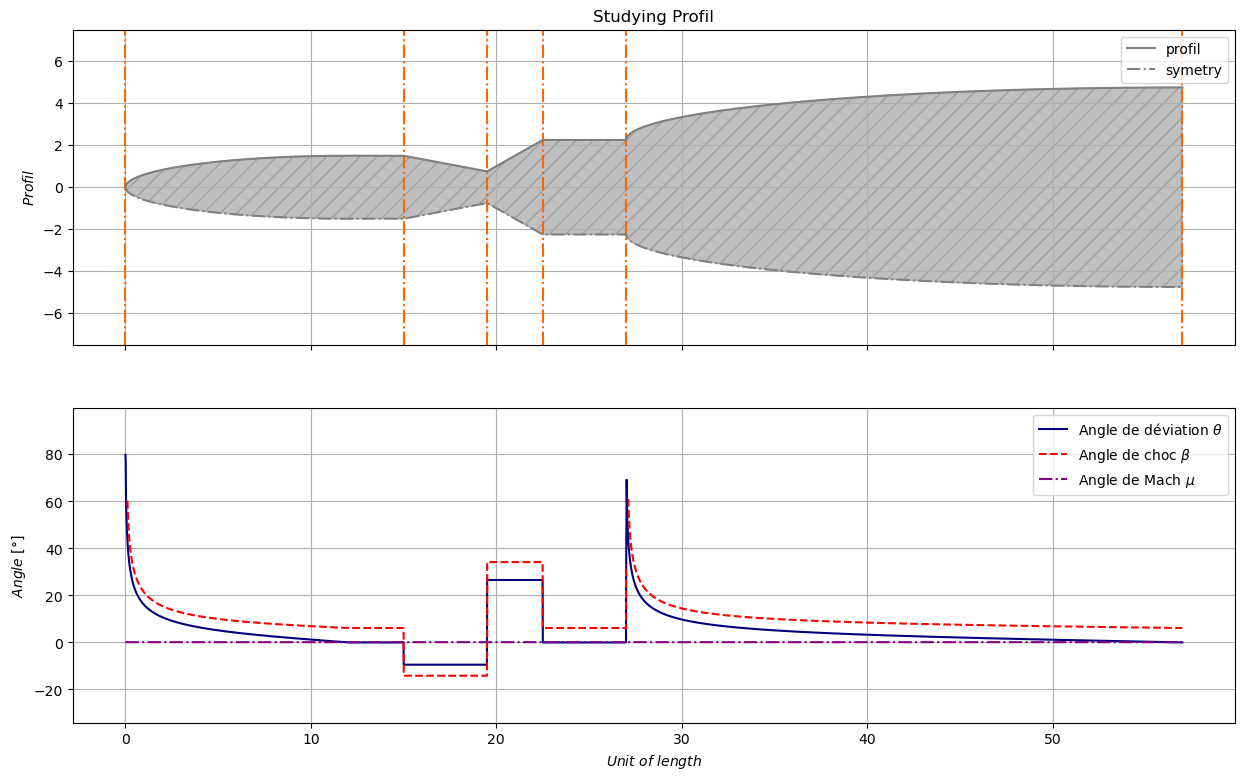

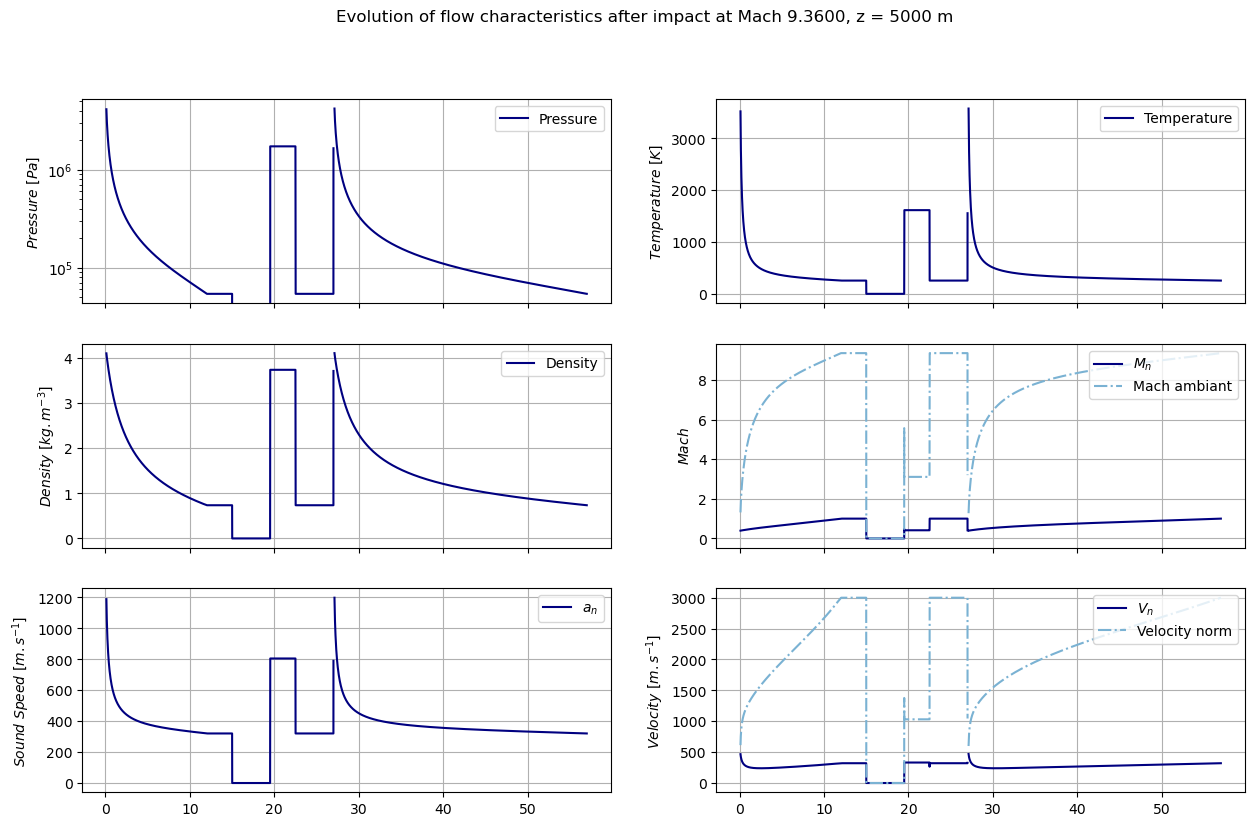

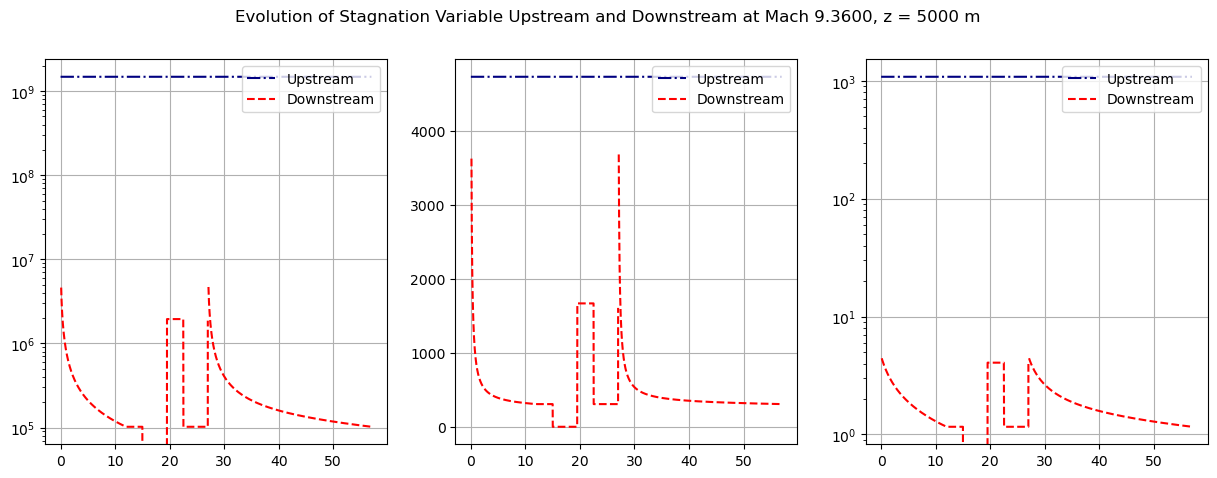

In [126]:
Hyper_OS = HypersonicObliqueShock(Atmosphere, directory_path, z, profil_dictionary, FreeFlowVelocity)